In [18]:
import csv
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import re

def spellProcessor(word):
    word = word.lower()
    word = word.replace("gyftis", "gifts")
    word = word.replace("gether", "gather")
    word = word.replace("spirituall", "spiritual")
    word = word.replace("feythfull", "faith")
    word = word.replace("wytnes", "witness")
    word = word.replace("almes", "alms")
    word = word.replace("desyre", "desire")
    word = word.replace("selfe", "self")
    word = word.replace("saffely", "safely")
    word = word.replace("realme", "realm")
    word = word.replace("acte", "act")
    word = word.replace("fourme", "form")
    word = word.replace("subiectes", "subjects")
    word = word.replace("theyr", "their")
    word = word.replace("kynde", "kind")
    word = word.replace("kynge", "king")
    word = word.replace("kyndes", "kinds")
    word = word.replace("vpon", "unto")
    word = word.replace("purueyours", "purveyors")
    word = word.replace("highnes", "highness")
    word = word.replace("euery", "every")
    word = word.replace("quene", "queen")
    word = word.replace("quenes", "queens")
    word = word.replace("whiche", "which")
    word = word.replace("bloude", "blood")
    word = word.replace("soueraine", "sovereign")
    word = word.replace("enactd", "enacted")
    word = word.replace("vs", "us")
    
    word = re.sub('\d','', word)
    return word

stopWords = [",","the","and","of","or","to","in","shall","be","that","any","by",".",
              "such","as","this","for","same","all","said","other","'s",";",
              "her","is","every","[","]","they","within", "our", "not", "so",
              "made", "no", "then", ":", "do", "from", "if", "it", "which", "at", "with",
             "thereof","upon", "a", "because", "used", "some", "but", "aforesaid", "also",
             ")","(", "what", "&", "may", "are", "their", "them", "sayde", "suche", "shalbe", "anye", "sayd",
             "thesaid", "/", "...", "/", "either", "haue", "vnto", "thy", "did", "was", "were", "have", "thee", 
             "your", "thou", "unto", "hath", "had", "went","kl"]

In [19]:
input_data = list()
row_count = 0

metadata=list()
with open('../vtexts/vtextMetadata.csv', 'rt') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # deal with the header
        if row_count != 0:
            metadata.append(row)   
        row_count += 1
print("read",row_count,"lines")

read 69 lines


In [20]:
# change to sovereign
labels = [i[3] for i in metadata]
files = list()
for i in metadata:
    fn = "../vtexts/" + i[0]
    files.append(fn)
    
vectorizer = CountVectorizer(
    input='filename',
    lowercase=True,
    ngram_range=(1,3),
    strip_accents=None, 
    preprocessor=spellProcessor, 
    stop_words=stopWords)

In [21]:
# get document term matrix
dtm = vectorizer.fit_transform(files)

# convert to tf-idf frequencies (to account for differences in text lengths)
tfidf_transformer = TfidfTransformer()
dtm_tfidf = tfidf_transformer.fit_transform(dtm)

In [22]:
# attempt to deal with imbalanced dataset
for c in set(labels):
    print("Class: {0}, Documents: {1}".format(c,labels.count(c)))

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',
                                     np.unique(labels),
                                     labels)

Class: Edward VI, Documents: 9
Class: James I, Documents: 7
Class: Henry VIII, Documents: 14
Class: Charles I, Documents: 12
Class: Mary I, Documents: 8
Class: Elizabeth I, Documents: 18


In [23]:
# create and fit model using Support Vector Machine (SVM)
clf = SGDClassifier(tol=None,class_weight="balanced",max_iter=1000).fit(dtm_tfidf, labels)

In [24]:
# this function will return total count of a term in the vocabulary
def get_counts(term):
    widx = vectorizer.vocabulary_[term]
    return(dtm.sum(axis=0)[0,widx])

def get_class_representation(term):
    widx = vectorizer.vocabulary_[term]
    cd = dict()
    
    # initialize
    for c in set(labels):
        cd[c] = 0
    for i,c in enumerate(labels):
        cd[c] += dtm[i,widx]
    return(cd)

In [25]:
# what are our top terms?
vocab_sums = dtm.sum(axis=0)
sorted_vocab = [(v, vocab_sums[0, i]) for v, i in vectorizer.vocabulary_.items()]
sorted_vocab = sorted(sorted_vocab, key = lambda x: x[1], reverse=True)

# display top twenty words
for i in range(1,20):
    print(sorted_vocab[i][0],"->",sorted_vocab[i][1])

his -> 14499
lord -> 11610
him -> 9640
god -> 7863
my -> 7689
will -> 6035
me -> 5766
we -> 5683
you -> 4981
there -> 4950
ye -> 4892
day -> 4739
man -> 4600
when -> 4489
men -> 4224
king -> 4151
one -> 4087
out -> 4052
on -> 3917


In [26]:
# produce key features for each class
feature_names = vectorizer.get_feature_names()
feature_list=dict()

for cn, cl in enumerate(clf.classes_):
    print("Key features for {}:".format(cl))

    terms = np.argsort(clf.coef_[cn])
    values = clf.coef_[cn].ravel()[np.argsort(clf.coef_[cn].ravel())]

    # convert to lists
    kterms = terms[-50:].tolist()
    kvalues = values[-50:].tolist()
    
    # reverse ordering
    kterms.reverse()
    kvalues.reverse()
    
    feature_list[cl] = list()

    for i, t in enumerate(terms):
        v = np.round(values[i],3)
        feature_list[cl].append((feature_names[t],v))
    
    for i, t in enumerate(kterms):
        v = np.round(kvalues[i],3)
        print("{0} ({1})".format(feature_names[t],v),end=", ")
    print('\n')

Key features for Charles I:
cor (0.582), rome (0.558), synod (0.53), isa (0.49), synod etc (0.484), matt (0.476), ii (0.46), gods (0.446), ps (0.438), eph (0.437), etc (0.409), recreation (0.397), hob (0.391), swear (0.391), cannot etc (0.381), doe (0.355), us (0.326), psal (0.32), mat (0.3), you cannot etc (0.272), recreations (0.258), government (0.248), acts (0.248), prelates (0.247), lawful (0.241), his (0.239), doe believe (0.238), established (0.236), pet (0.231), you cannot (0.231), blessed (0.231), vain (0.223), vain cannot (0.218), yet vain cannot (0.218), good people (0.217), blasphemers (0.212), kingdom (0.21), will (0.208), gal (0.207), hell (0.203), tim (0.202), zion (0.201), yet vain (0.198), lawful recreation (0.198), rome rome (0.188), pope (0.184), articles church england (0.182), sin (0.182), reve (0.179), want (0.177), 

Key features for Edward VI:
master (0.774), thesaied (0.634), mastership (0.528), convict (0.5), grett (0.42), ij (0.403), ther (0.399), procession 

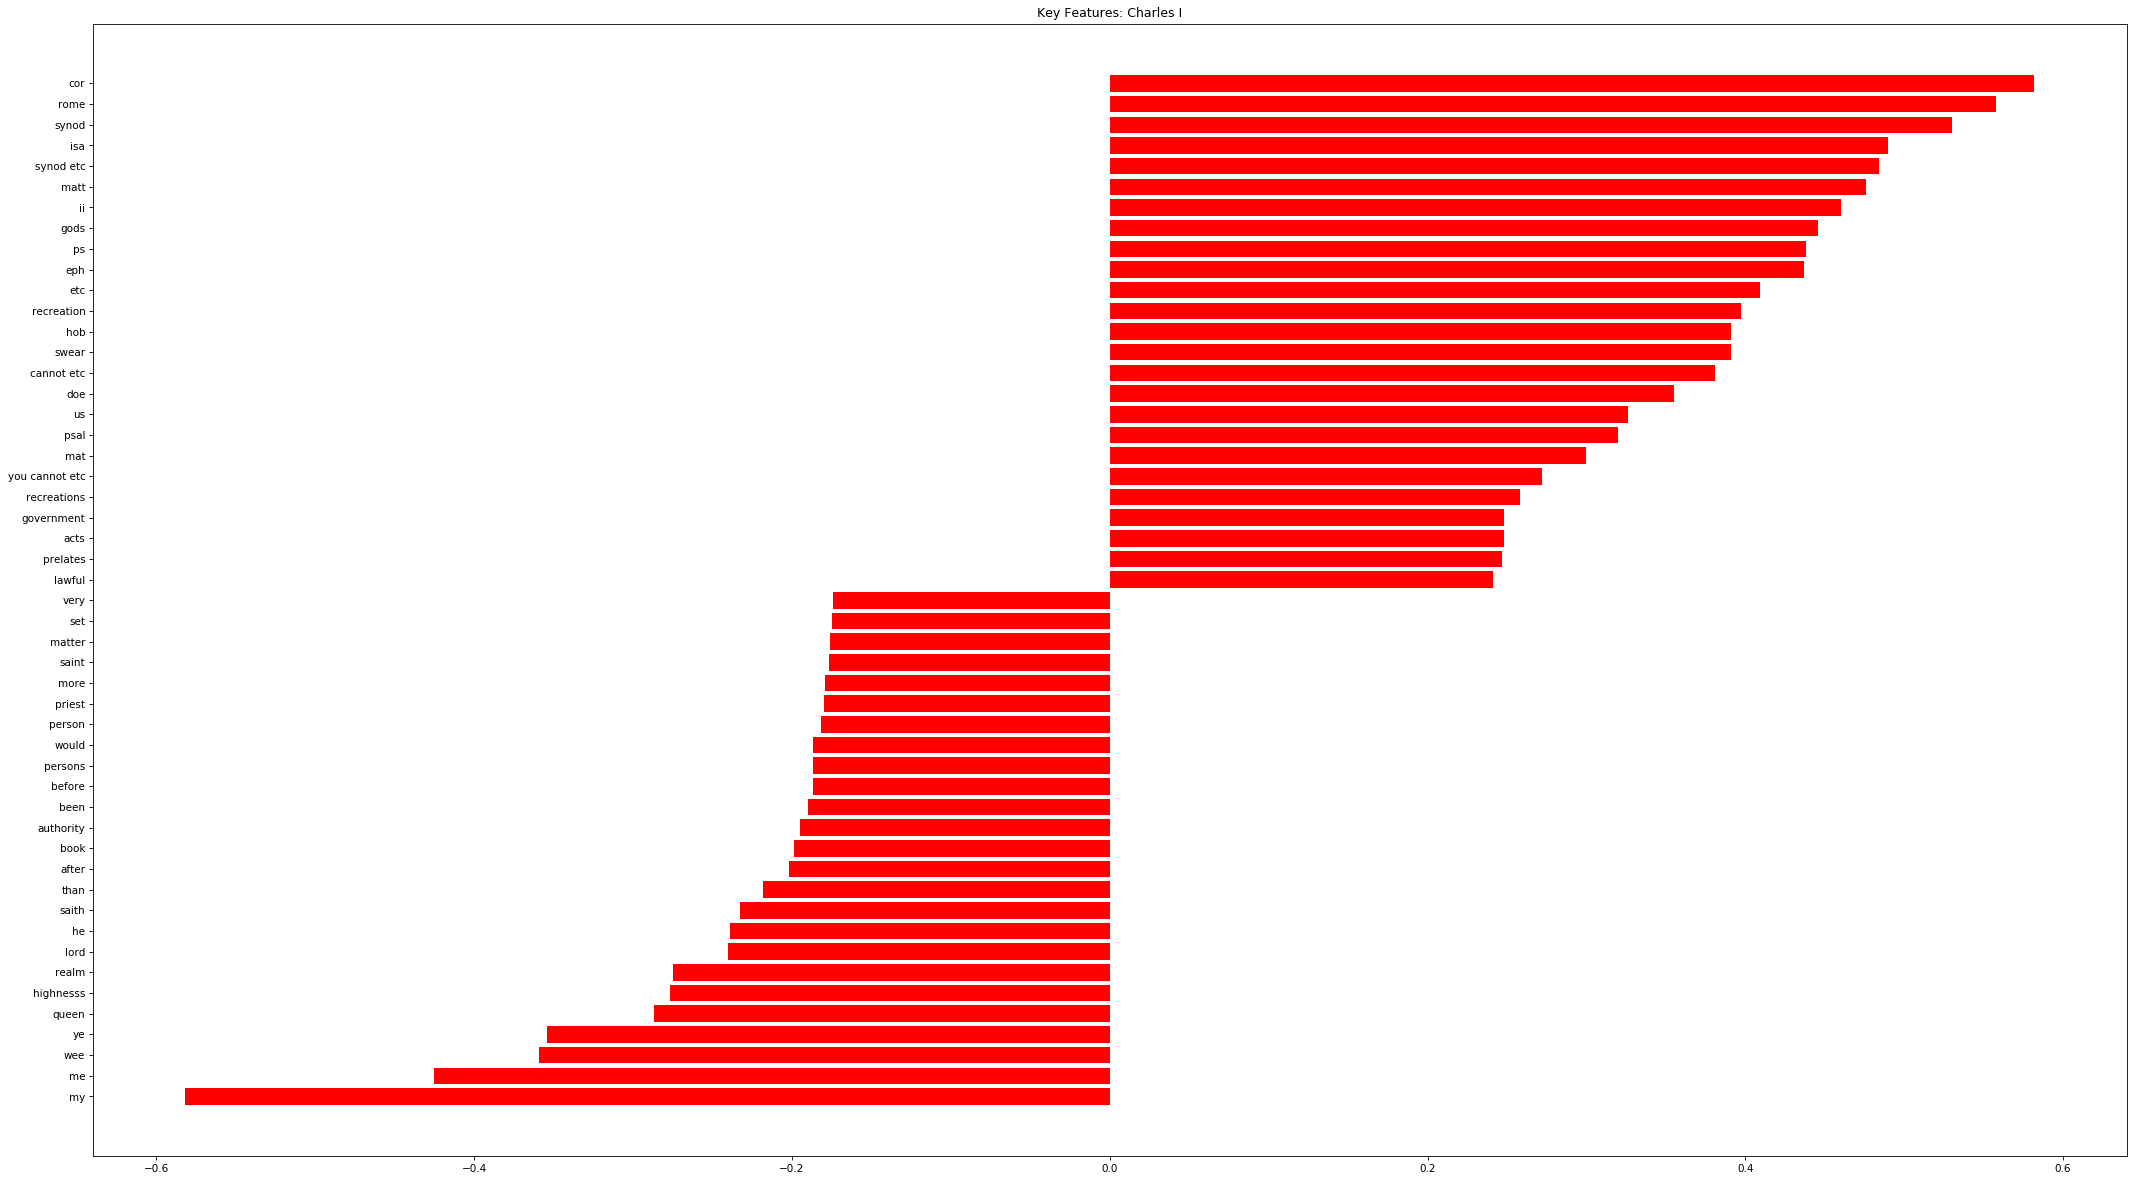

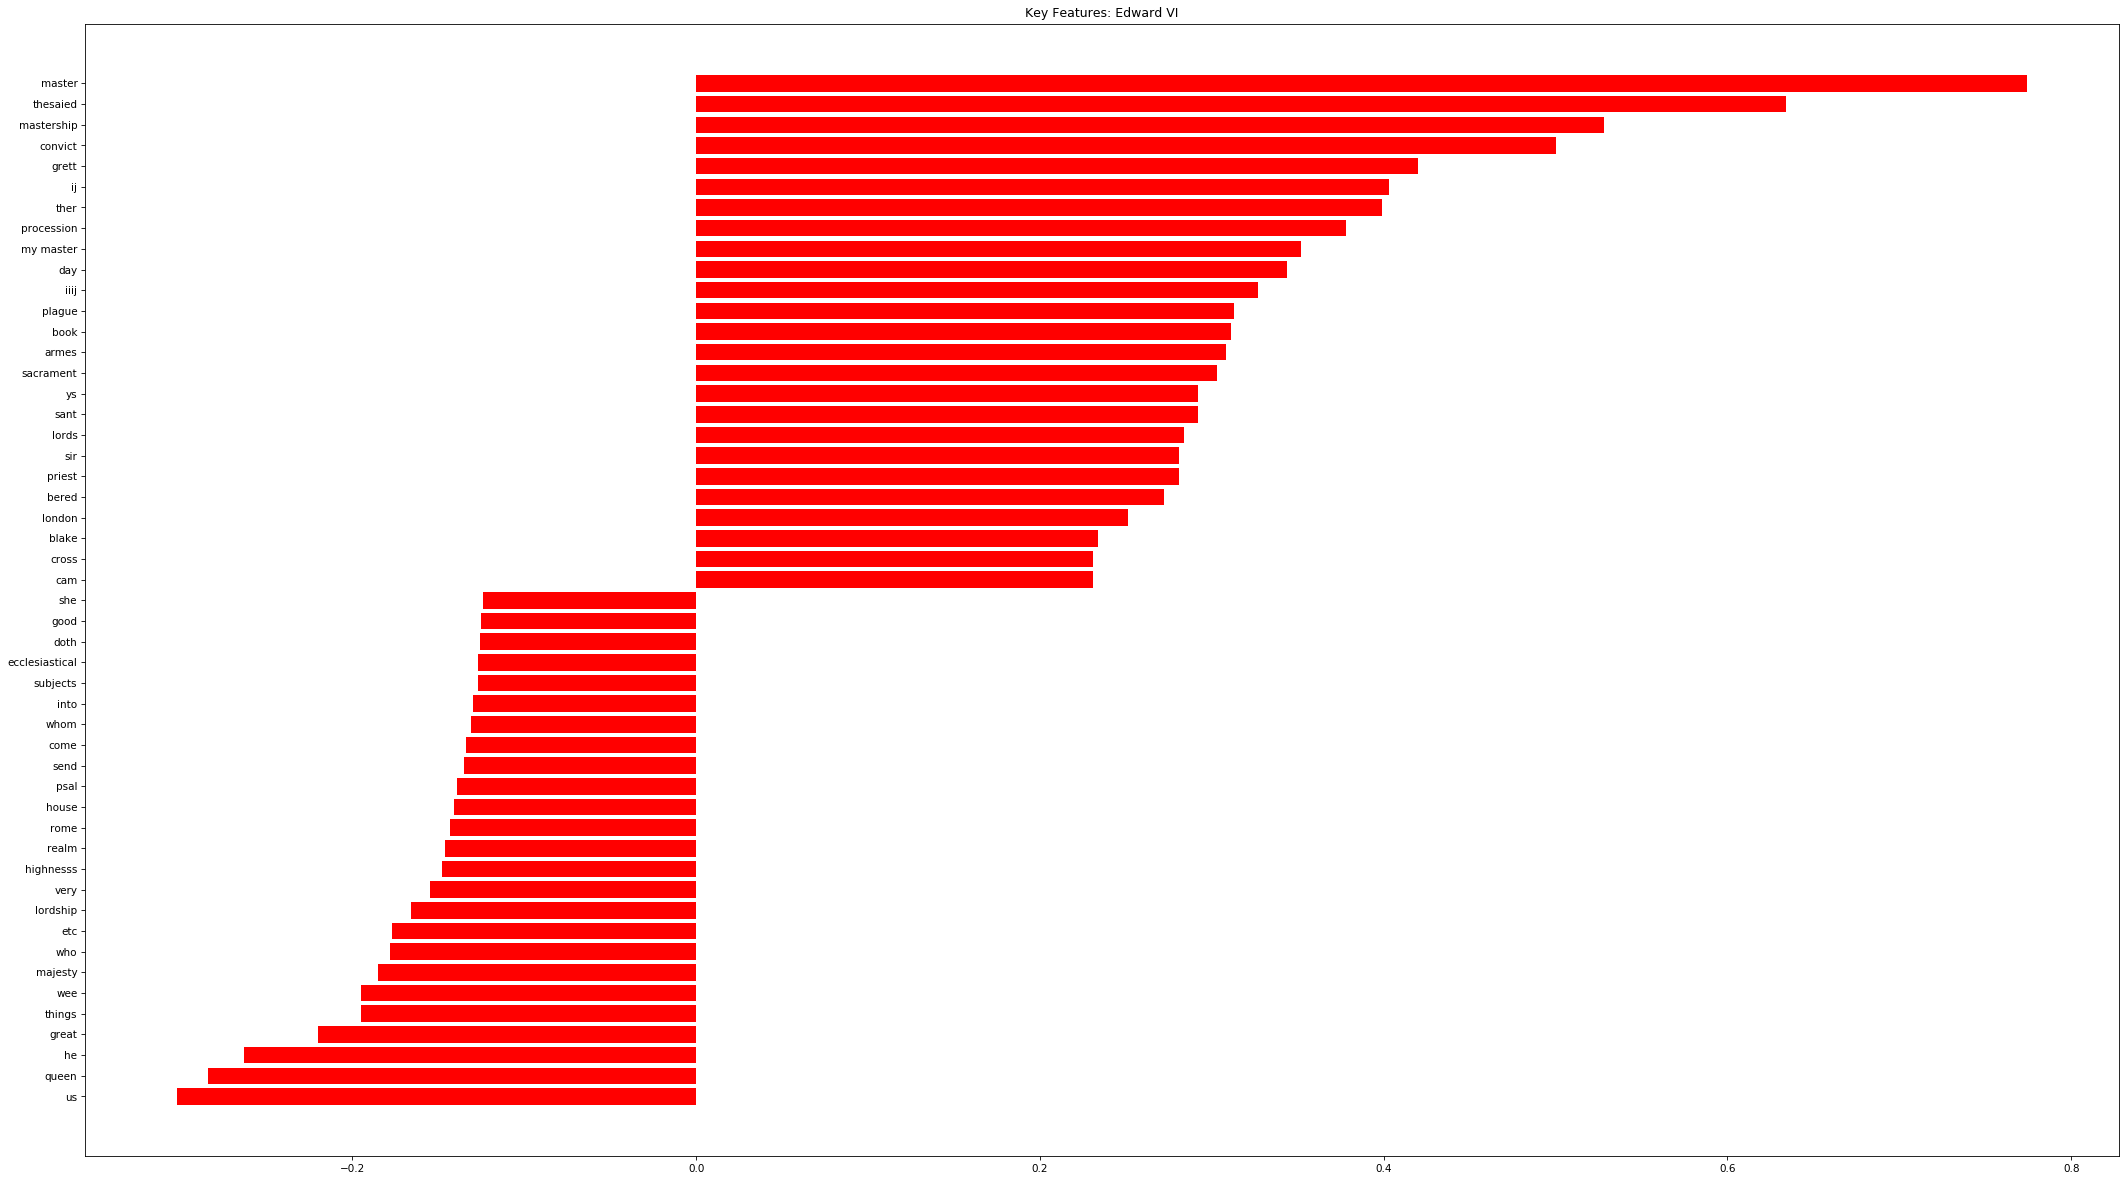

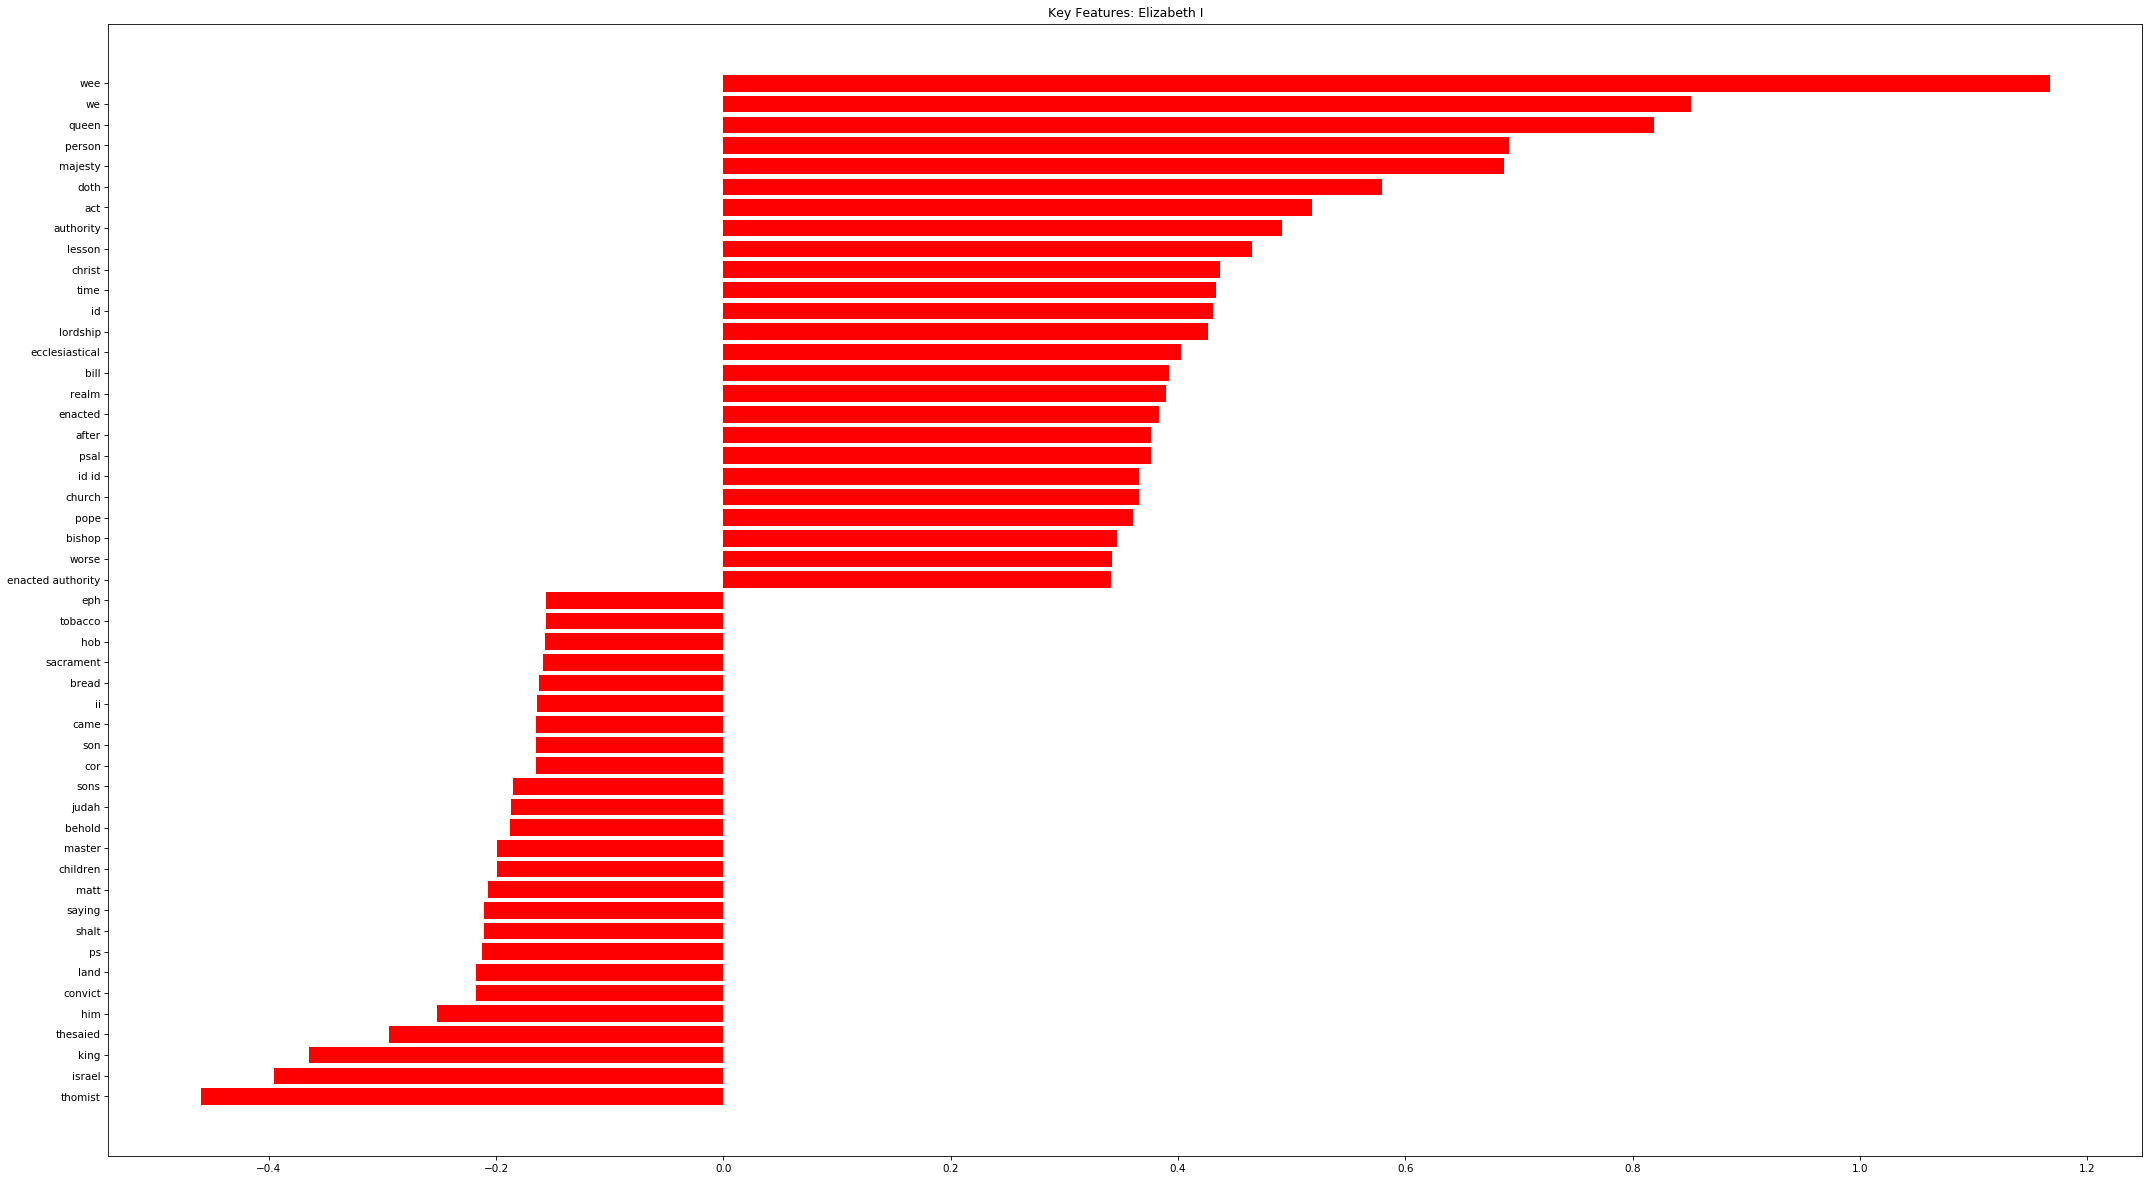

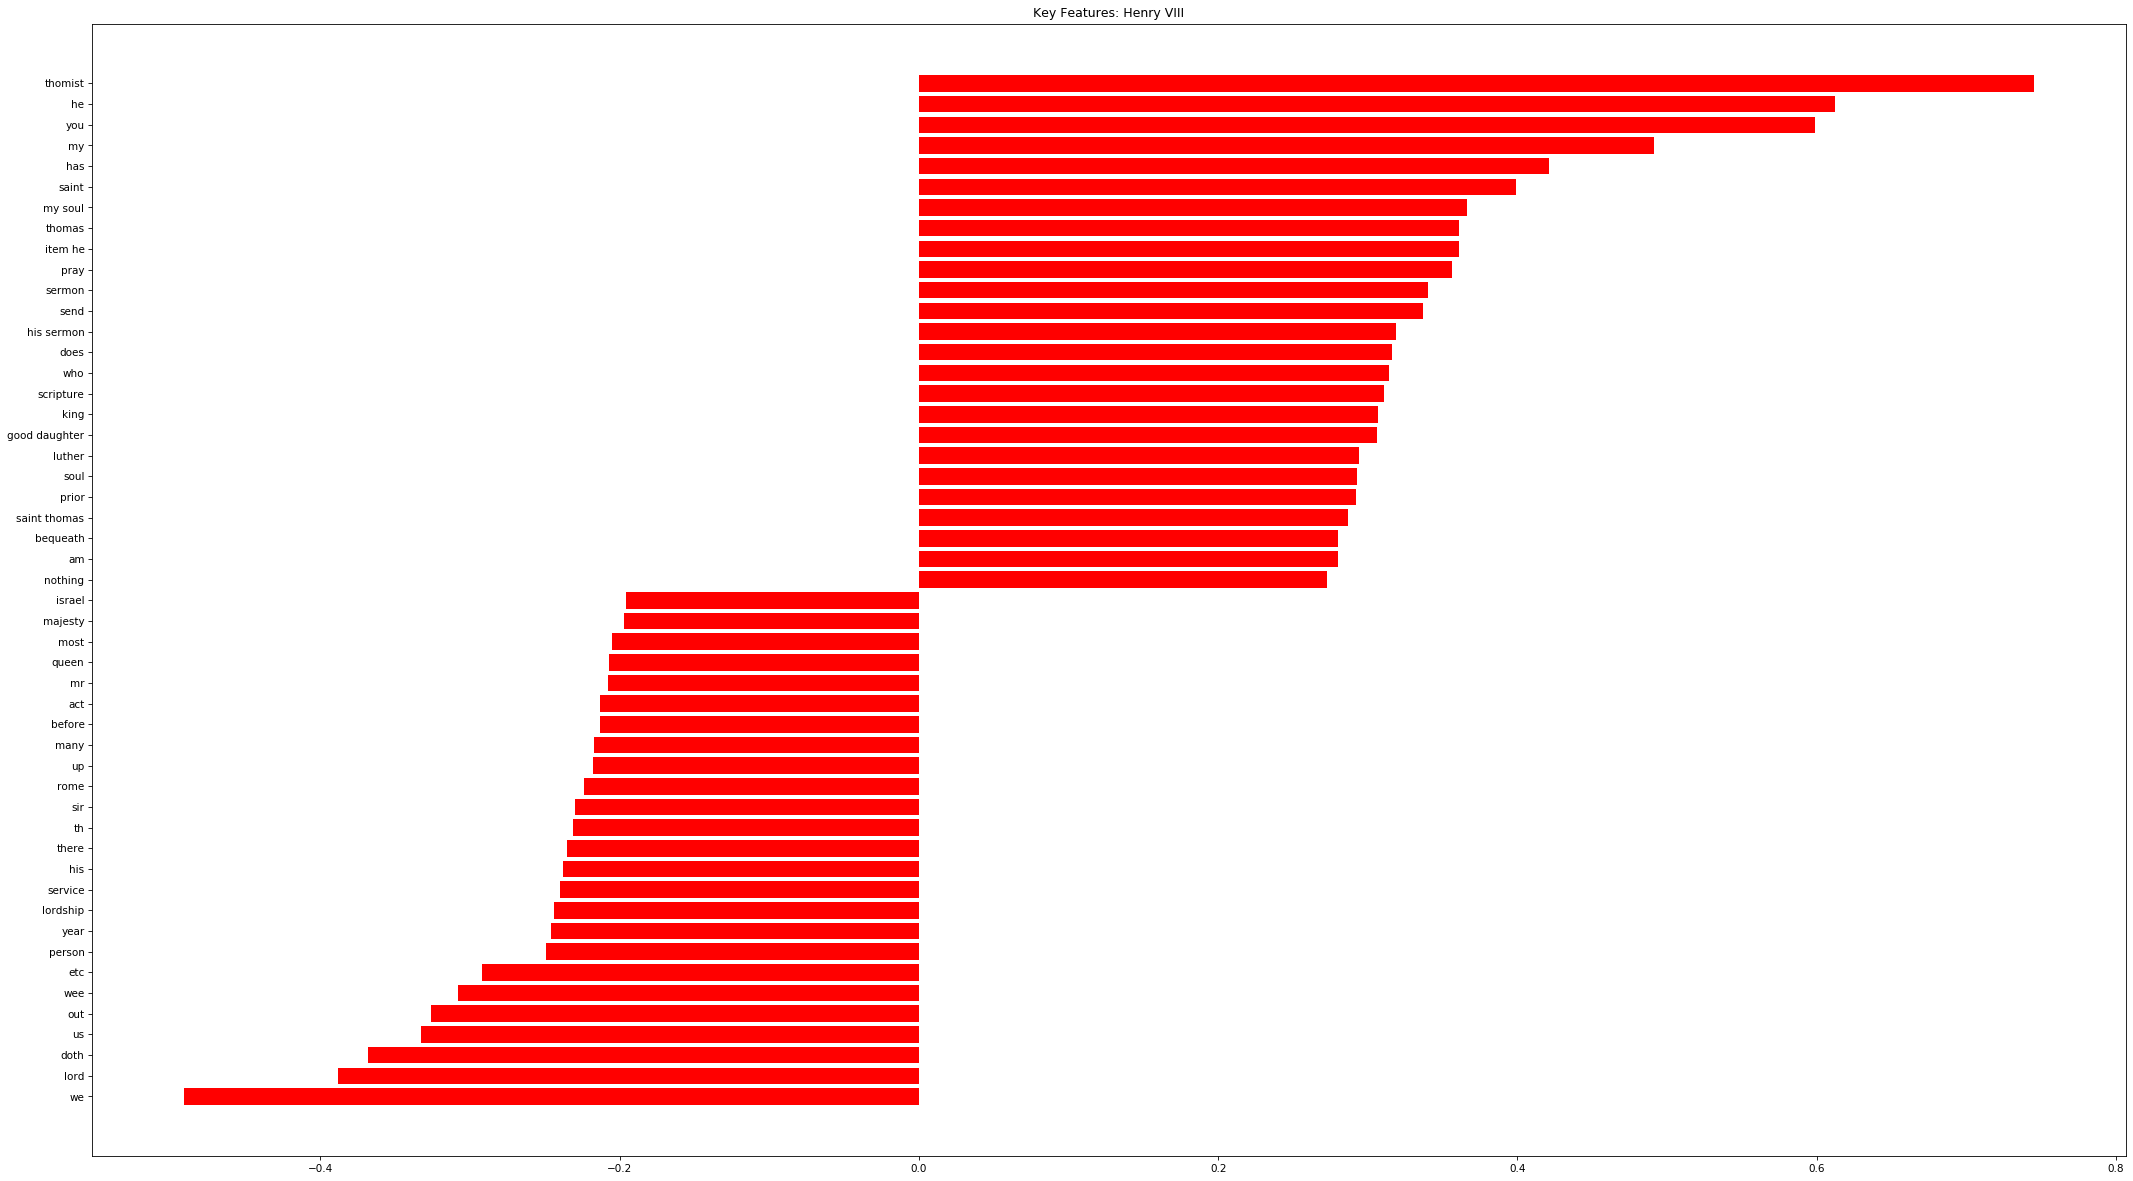

In [27]:
# reduce data
word_cloud_data=dict()
for cl in feature_list.keys():
    viz_words = feature_list[cl][:25] + feature_list[cl][-25:]
    word_cloud_data[cl] = dict()
    for i in feature_list[cl][:100]:
        word_cloud_data[cl][i[0]] = float(i[1])
        
    values = [x[1] for x in viz_words]
    kwords = [x[0] for x in viz_words]
    y_pos = range(len(values))

    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(35, 20), dpi=75)
    plt.barh(y_pos, values, align='center',tick_label=kwords,color="red")
    plt.title("Key Features: {0}".format(cl))
    plt.savefig(cl+'import-features.png')

Class: Charles I
Class: Edward VI
Class: Elizabeth I
Class: Henry VIII
Class: James I
Class: Mary I


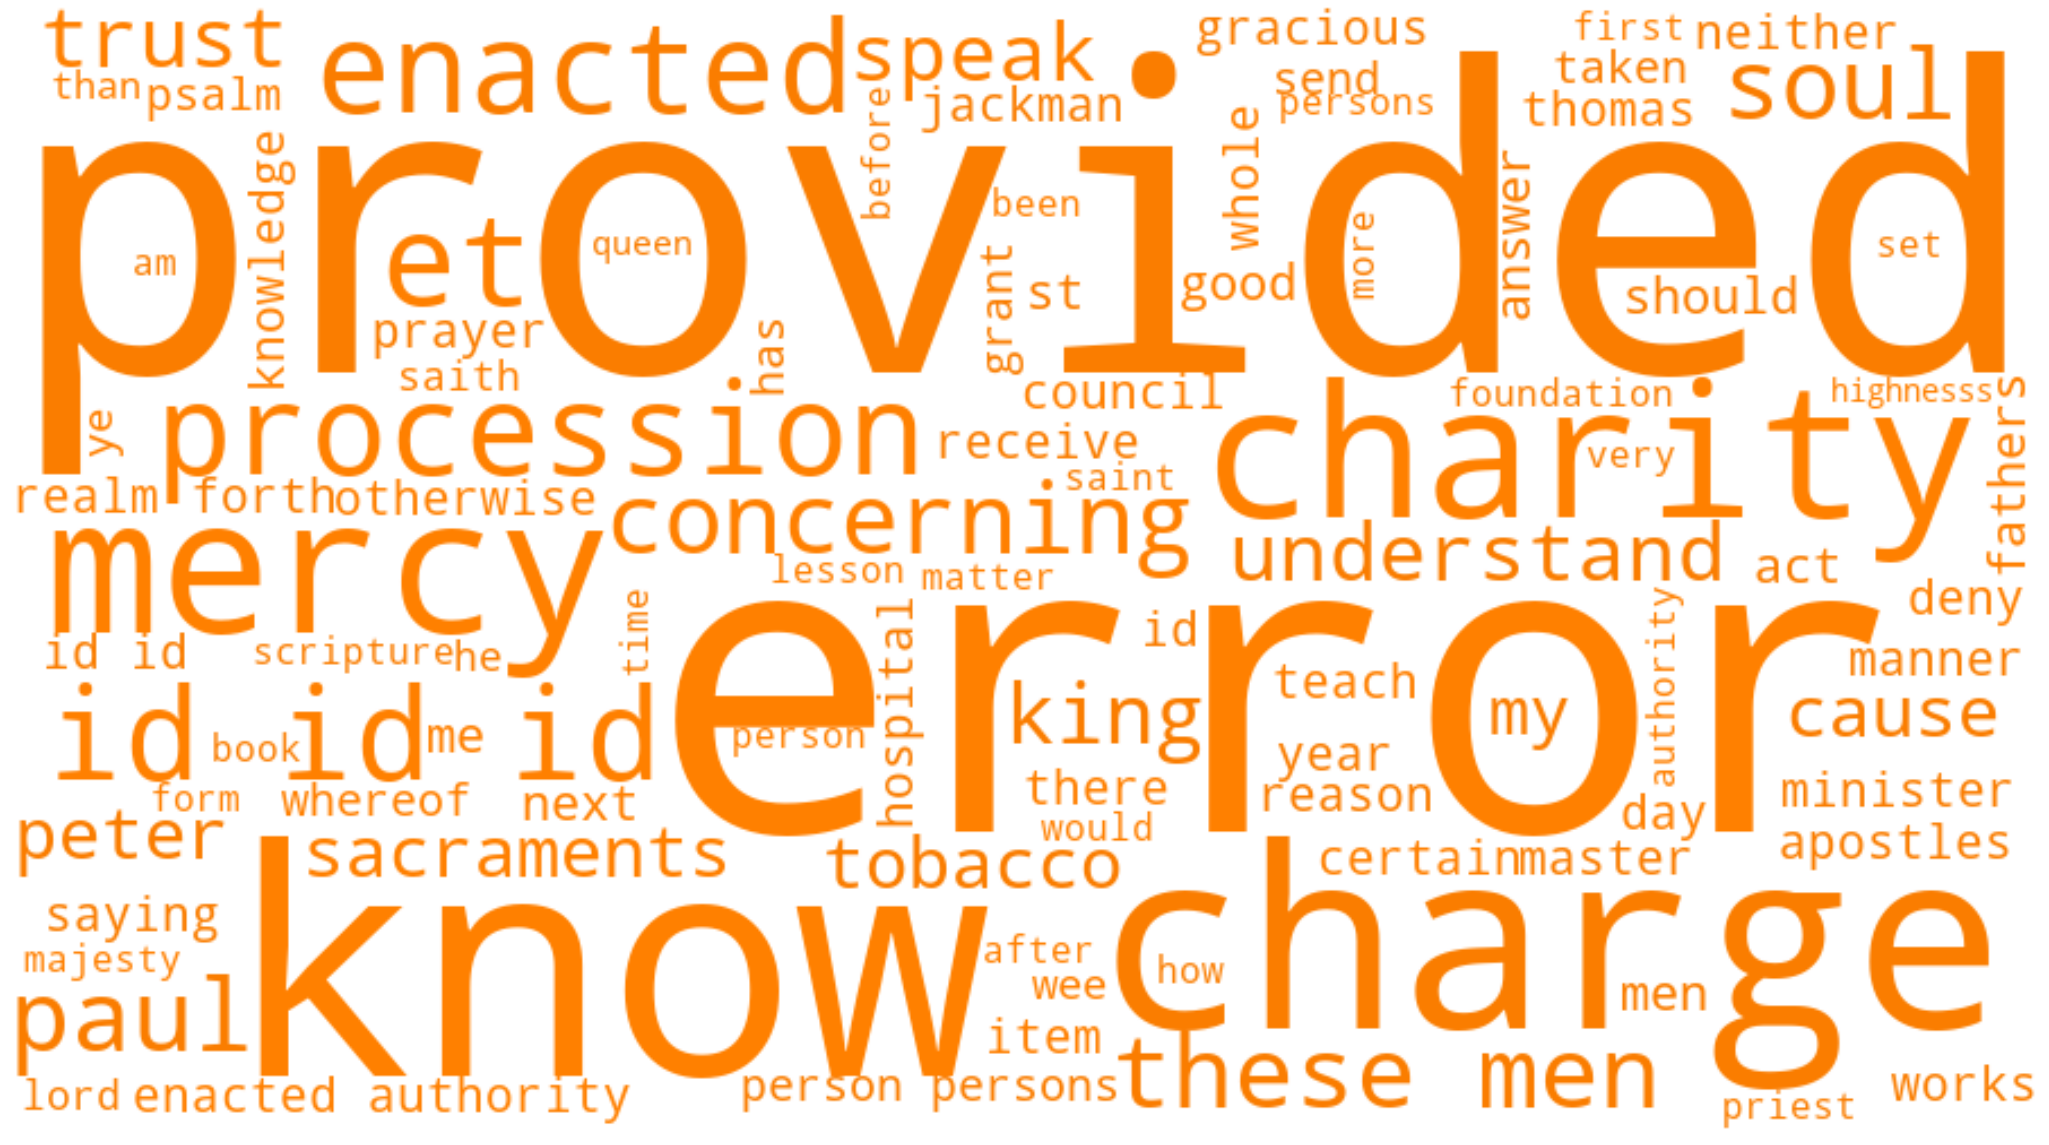

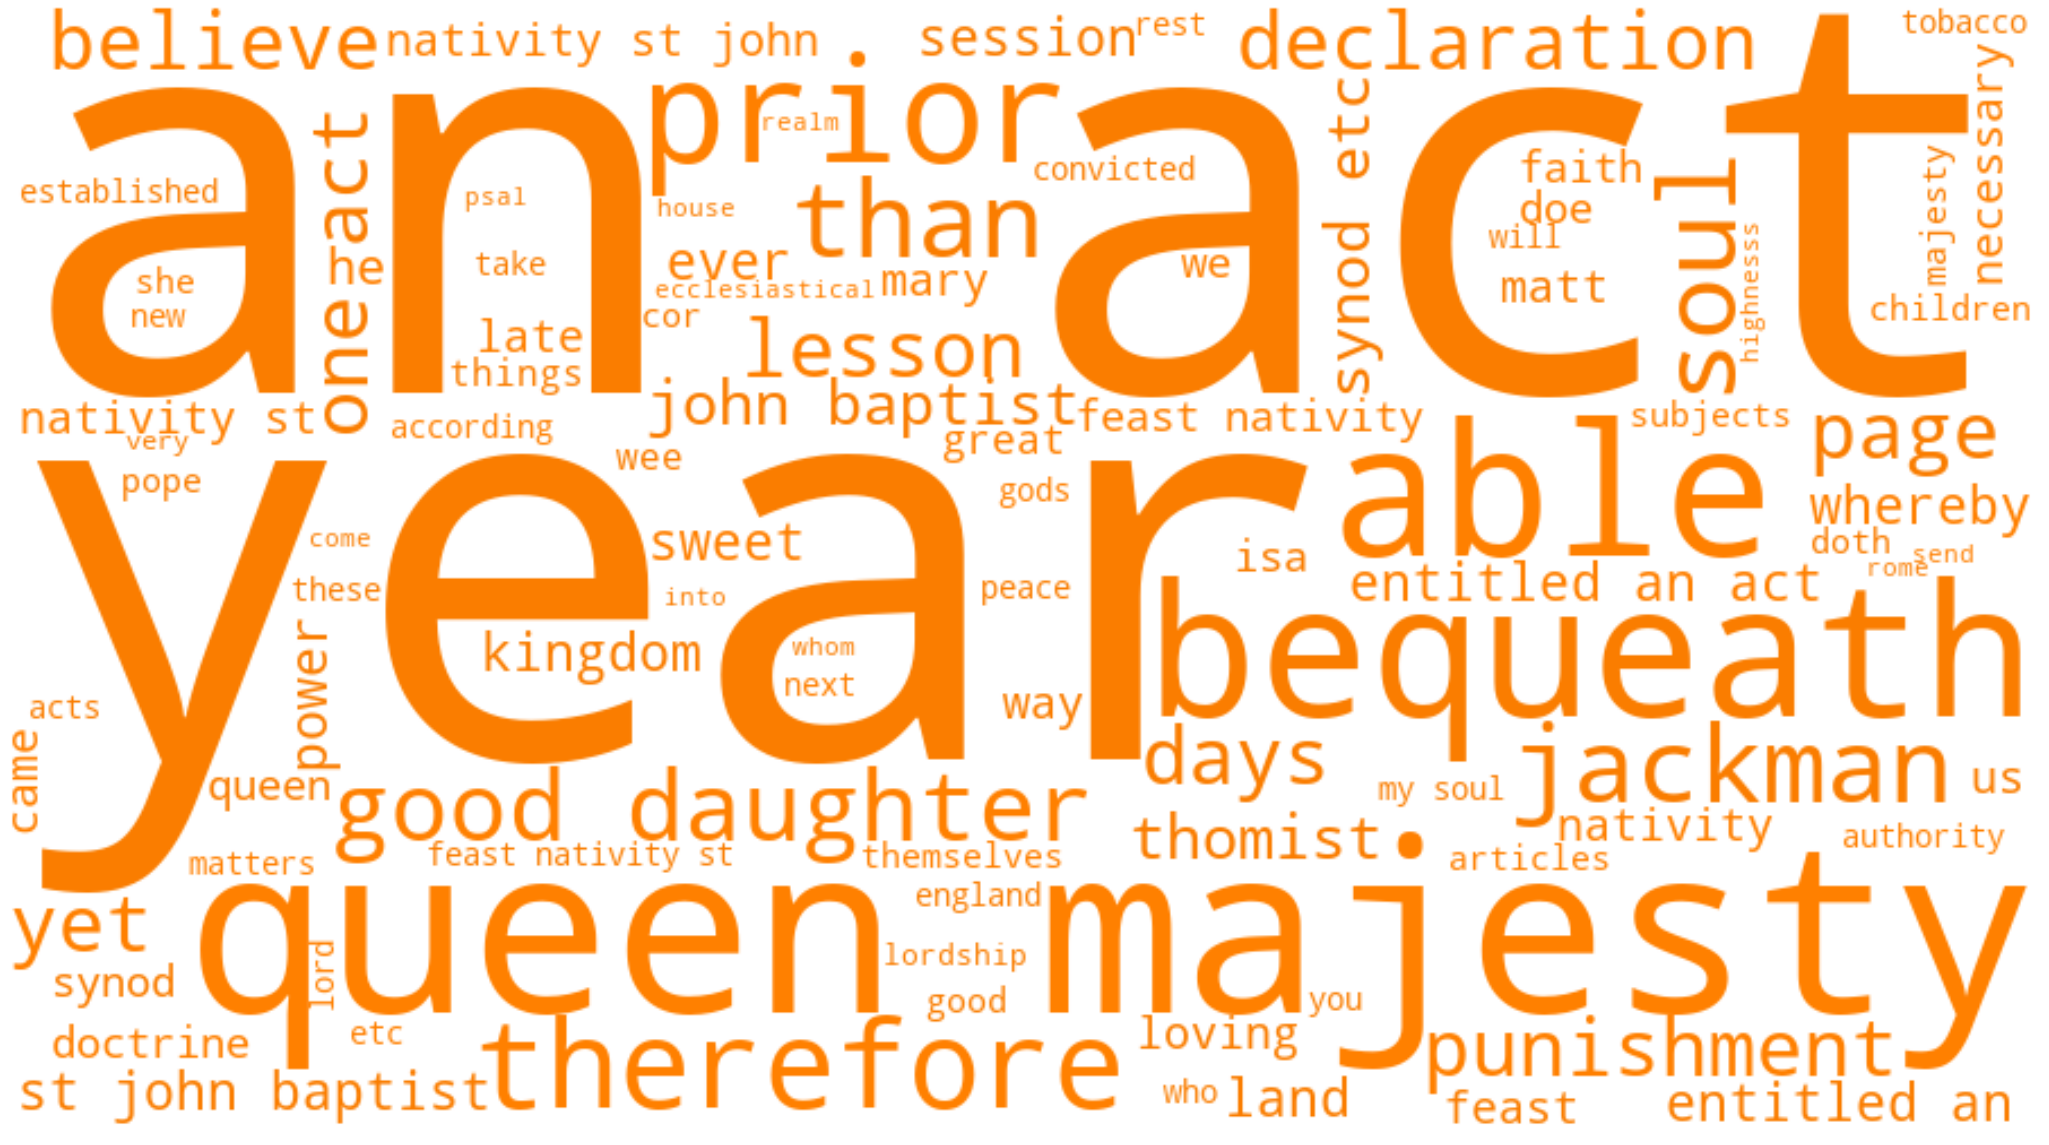

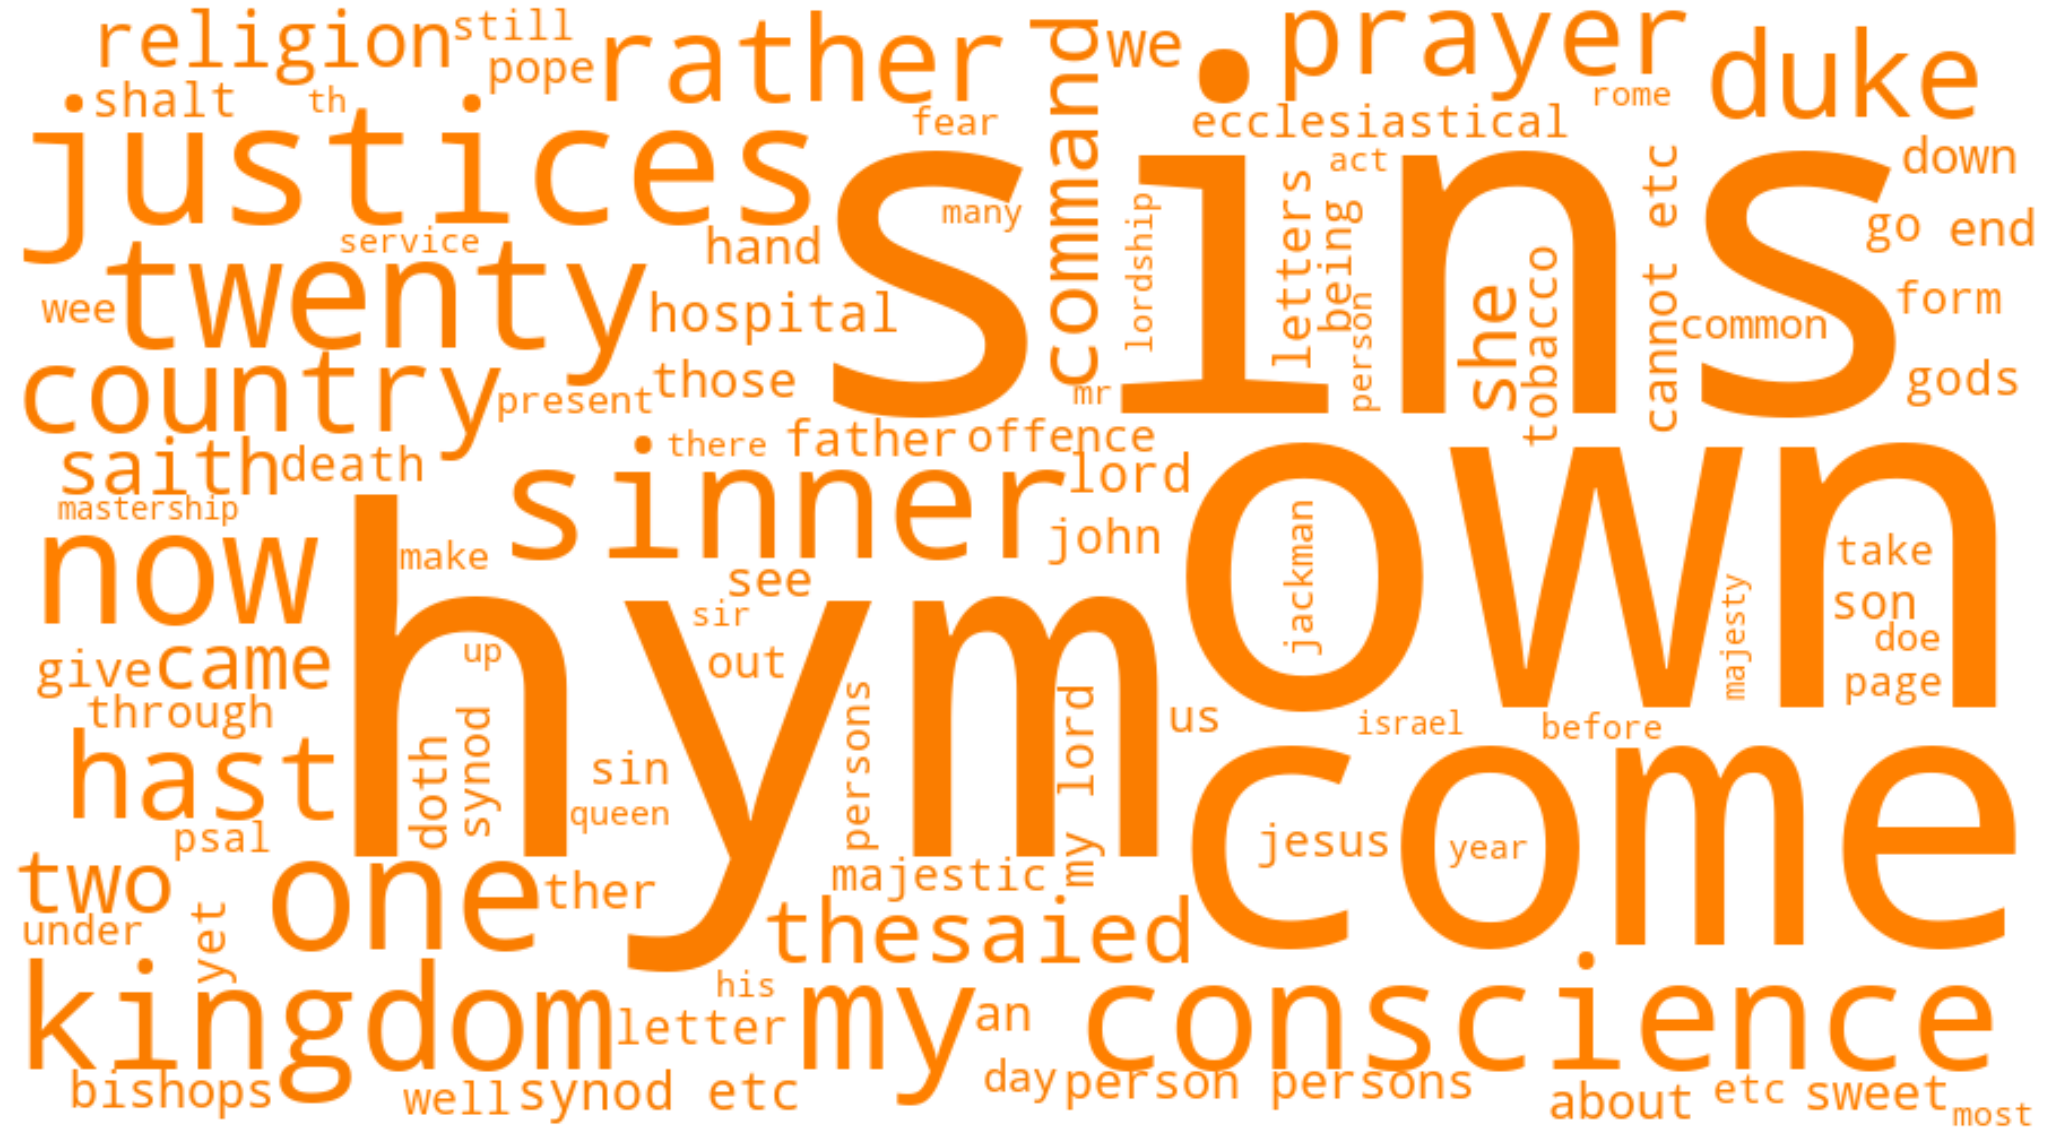

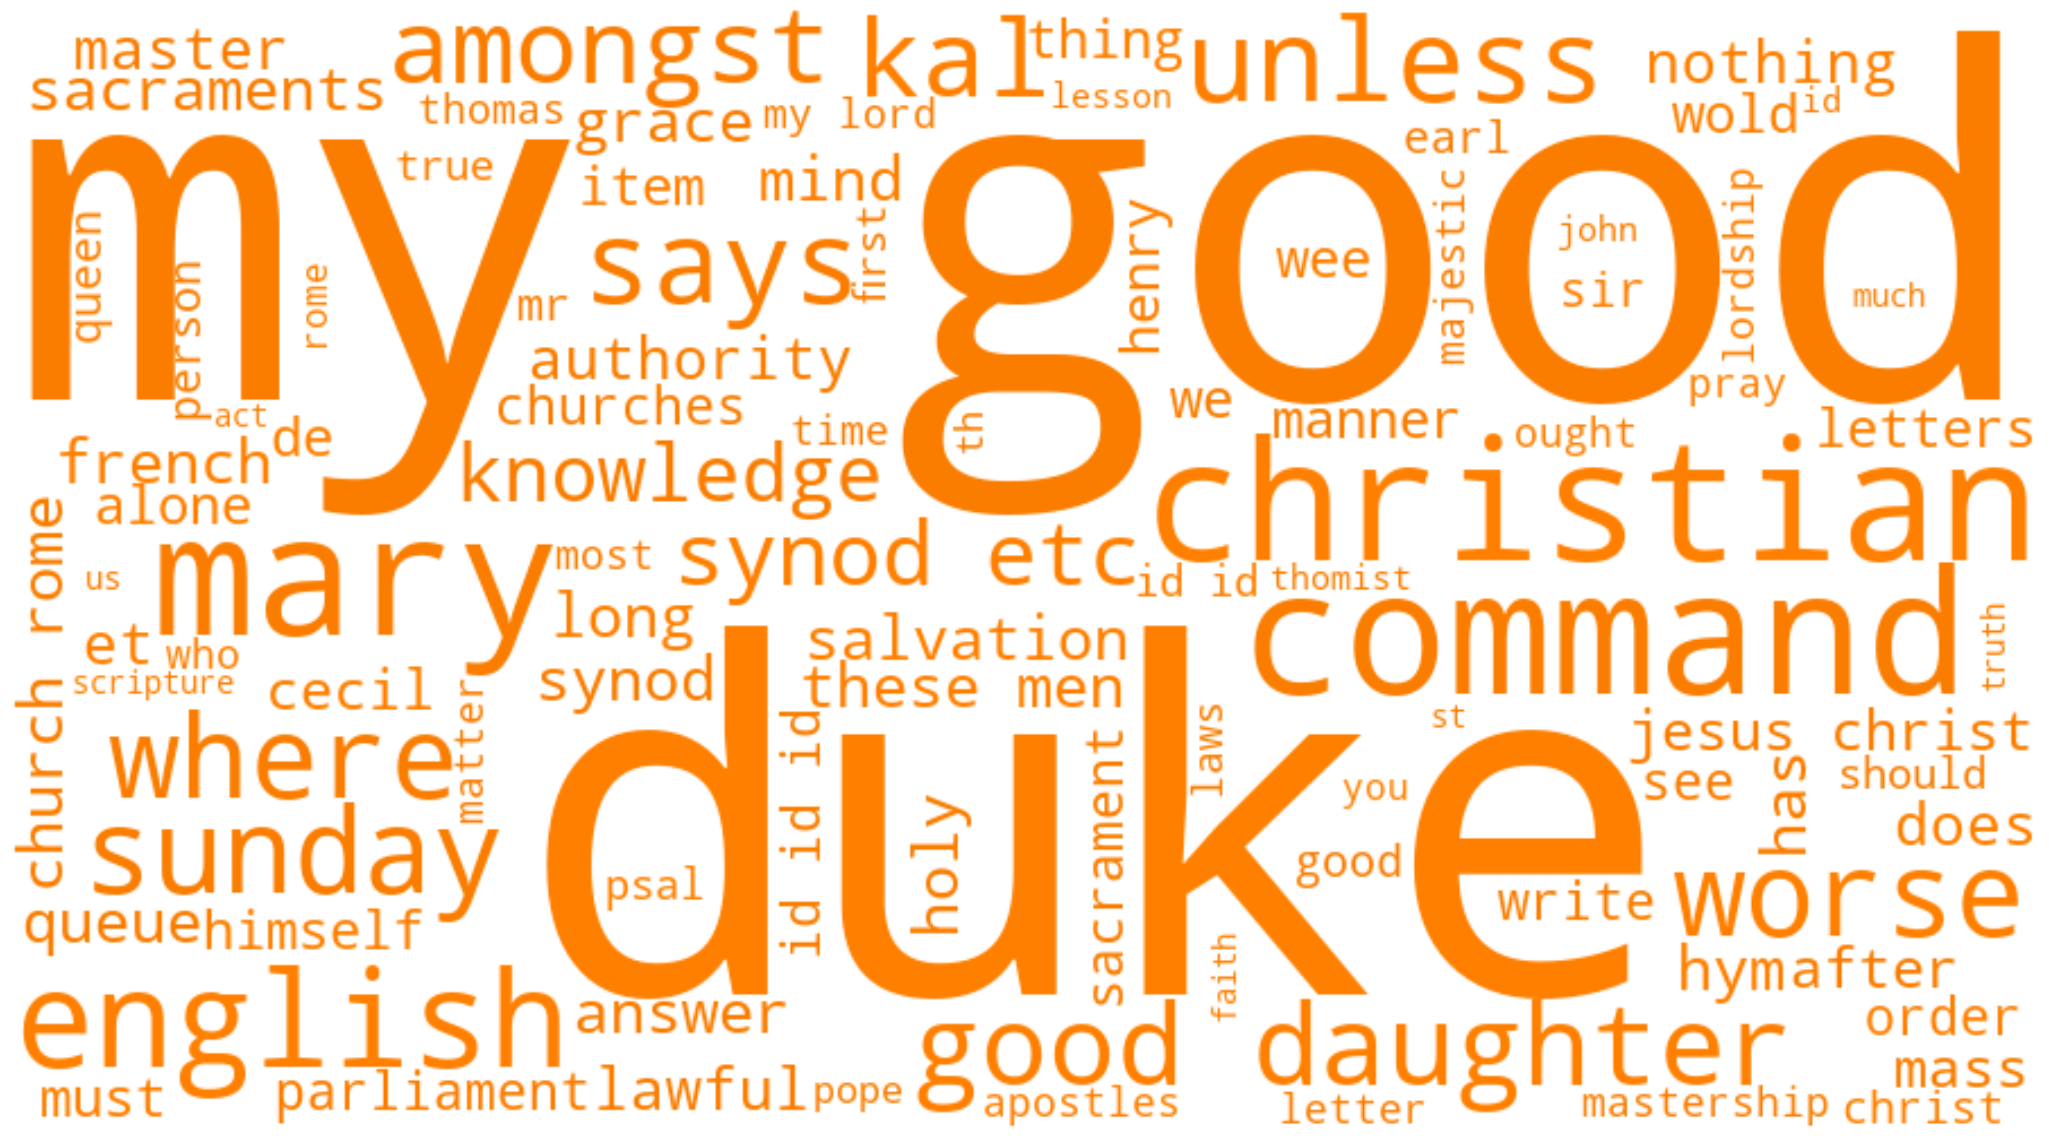

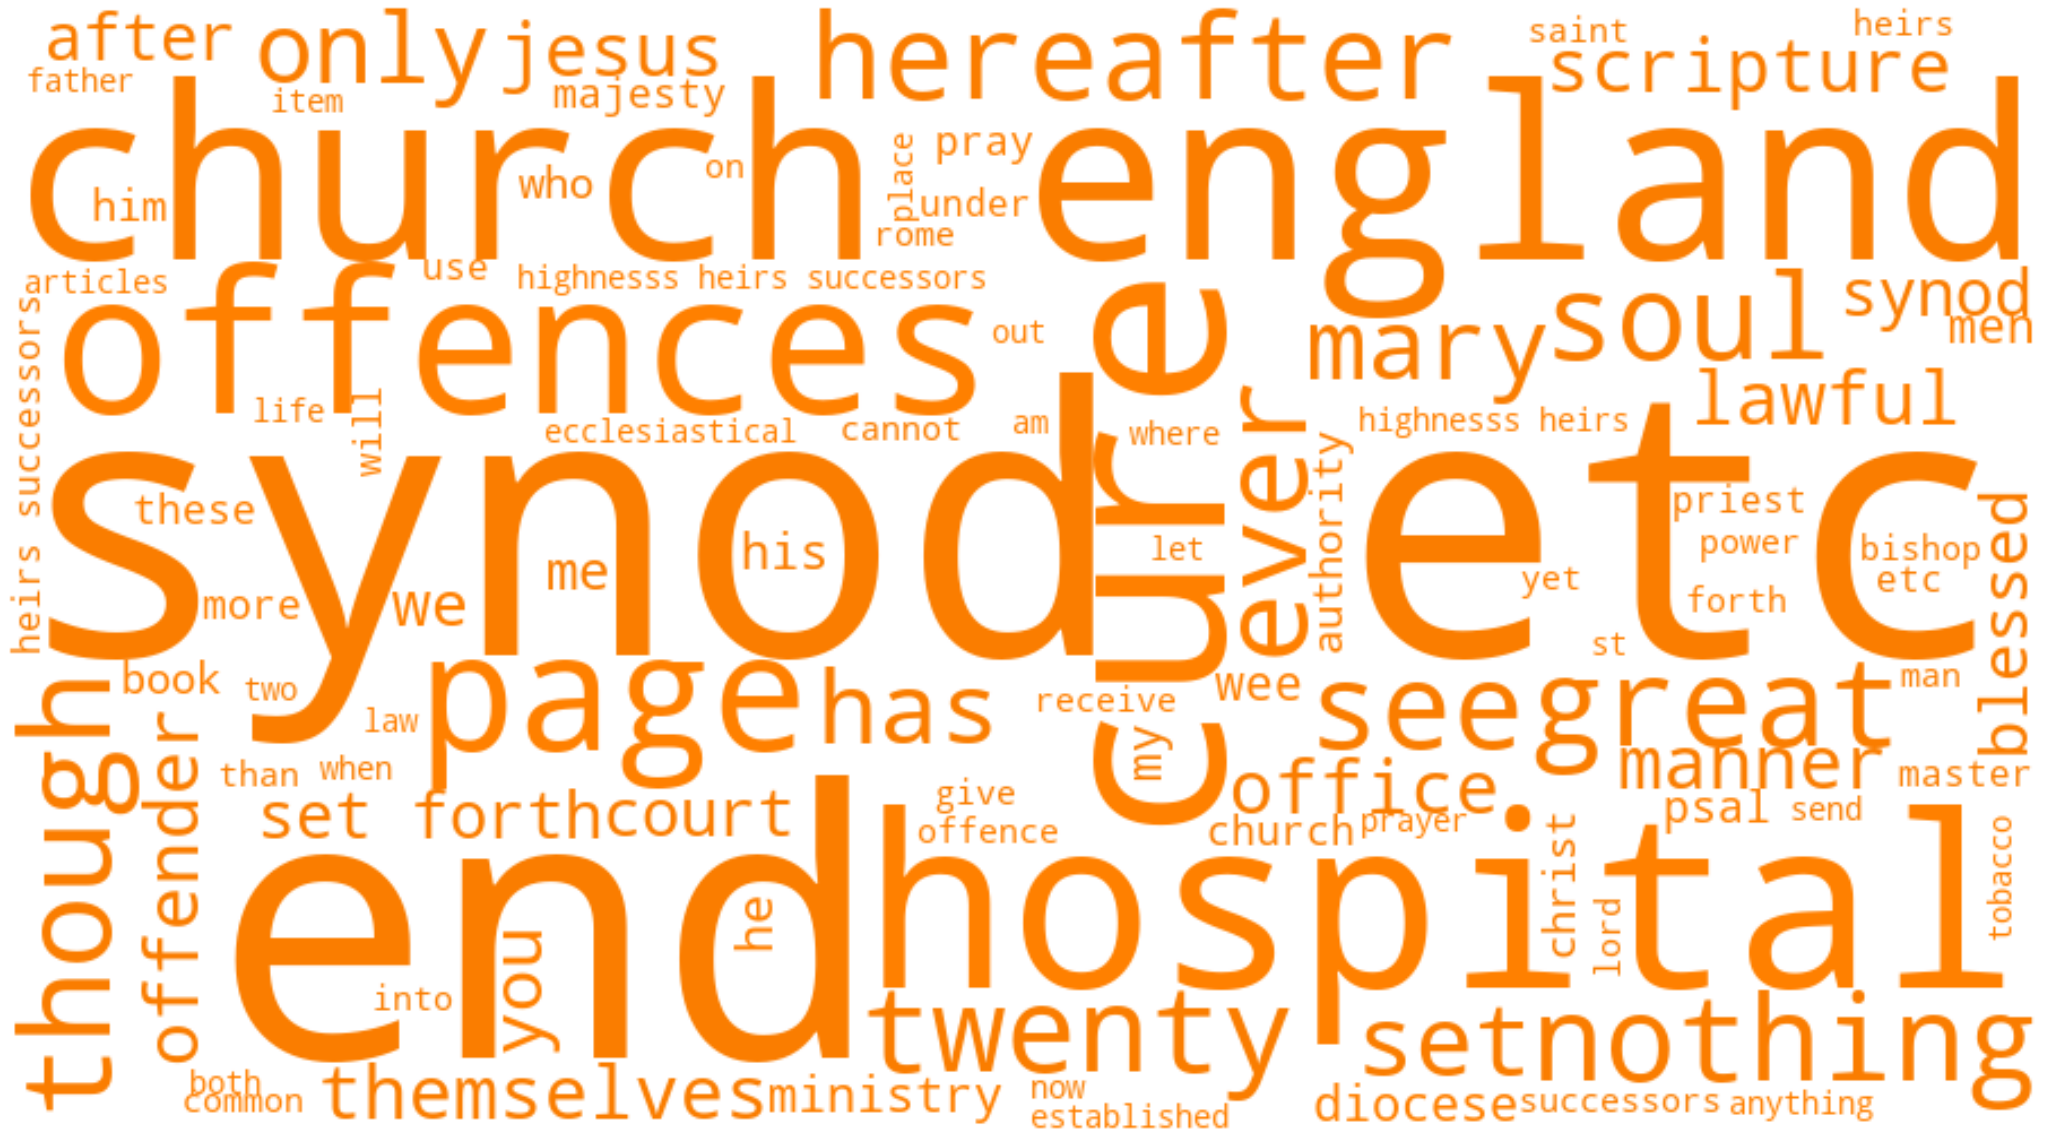

In [31]:
from wordcloud import WordCloud

def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(30,100%%, %d%%)" % np.random.randint(49,51))

# show most important features for each class:
for cl in word_cloud_data.keys():
    print("Class: {0}".format(cl))
    fig = plt.figure(figsize=(35, 20), dpi=75)
    wordcloud = WordCloud(background_color="white", width=900,height=500, max_words=1000,
                      relative_scaling=1).generate_from_frequencies(word_cloud_data[cl])
    wordcloud.recolor(color_func = color_func)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(cl+'wordcloud.png')